In [82]:
import boto3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Getting Tokens

In [163]:
TABLE = "domains"

def add_to_tokens_list(tokens, costs, items):
    for item in items:
        tokens[item["domain_name"]] = item["tokens"]
        costs[item["domain_name"]] = float(item["total_spent"]) #DynamoDB stores as Decimal

    return tokens, costs


def get_tokens():
    tokens = {}
    costs = {}

    dynamo = boto3.resource("dynamodb").Table(TABLE)

    res = dynamo.scan()
    tokens, costs = add_to_tokens_list(tokens, costs, res["Items"])

    while "LastEvaluatedKey" in res:
        res = dynamo.scan(ExclusiveStartKey=res["LastEvaluatedKey"])
        tokens = add_to_tokens_list(tokens, res["Items"])

    return tokens, costs

In [165]:
tokens, costs = get_tokens()
len(list(tokens.keys()))

26

In [166]:
#0=pharmacy, 1=ketamine, 2=cannabis, 3=cars, 4=other 
y = [0, 1, 0, 4, 2, 0, 2, 3, 1, 1, 0]

In [167]:
costs

{'prestigeglobalchem.com': 36.5,
 'omaghenshihtzuhome.com': 16.88,
 'southhilltoppuppies.com': 16.88,
 'johnbellteacupmaltese.com': 12.0,
 'CJKETAMINESTORE.NET': 55.0,
 'purechempharma.com': 24.0,
 'tomh.uk': 18.0,
 'monarchbulldogs-sa.com': 16.88,
 'jungleboyspacks.com': 16.88,
 'FAITHSTANDARDPHARMACY.COM': 12.0,
 'premiumdachshundpups.com': 12.0,
 'K2DRUGSTORE.COM': 18.0,
 'STRANDNORDBV.COM': 12.0,
 'SKYPHARMACYPILS.COM': 12.0,
 'vland-official.com': 123.66875982284546,
 'megaketaminestore.com': 24.0,
 'ketamineforsale.com': 28.88,
 'shihtzupuppiesforsale-us.com': 16.88,
 'MORRISAPOTEK.COM': 12.0,
 'percocetpills.com': 24.0,
 'pelluciddalmatianpuppieshome.com': 16.88,
 'DROMEDARYVILLE.COM': 25.0,
 'ROYALSITEYORKSHIRETERRIERPUPPIES.COM': 12.0,
 'PUPPYSTASHKENNELAU.COM': 12.0,
 'cutestdoodleskennel.com': 16.88,
 'bradsmaltipoos.com': 12.0}

# TFIDF Vectorizing

In [193]:
#Would use lambda for this but TfidfVectorizer is weird about lambdas
def identity(token):
    return token

tfidf = TfidfVectorizer(max_df=0.8, min_df=1, stop_words='english', use_idf=True, tokenizer=identity, preprocessor=identity, token_pattern=None)

tfidf_matrix = tfidf.fit_transform(list(tokens.values()))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [194]:
tfidf.stop_words_

{'contact', 'home'}

# KMeans

## Silhouette

In [195]:
s = []
k_max = 10

for k in range(2, k_max):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    
    s.append(silhouette_score(tfidf_matrix, kmeans.labels_, metric="euclidean"))

In [196]:
best_k = s.index(max(s)) + 2
best_k

8

Text(0, 0.5, 'Silhouette Score')

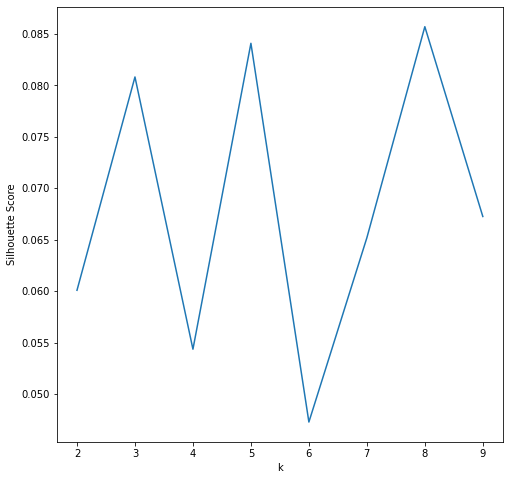

In [197]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(list(range(2, k_max)), s)
ax.set_xlabel("k")
ax.set_ylabel("Silhouette Score")

In [198]:
kmeans = KMeans(n_clusters=best_k)

kmeans.fit(tfidf_matrix)

clusters = kmeans.labels_.tolist()

In [199]:
domains = {'domain': tokens.keys(), 'cluster': clusters, 'total_spent': list(costs.values())}

df = pd.DataFrame(domains, index=[clusters], columns=['domain', 'cluster', 'total_spent'])

In [200]:
df['cluster'].value_counts()

5    9
1    5
3    4
4    3
2    2
0    1
6    1
7    1
Name: cluster, dtype: int64

In [201]:
df

,domain,cluster,total_spent
3,prestigeglobalchem.com,3,36.50000
2,omaghenshihtzuhome.com,2,16.88000
5,southhilltoppuppies.com,5,16.88000
5,johnbellteacupmaltese.com,5,12.00000
3,CJKETAMINESTORE.NET,3,55.00000
1,purechempharma.com,1,24.00000
6,tomh.uk,6,18.00000
5,monarchbulldogs-sa.com,5,16.88000
4,jungleboyspacks.com,4,16.88000
1,FAITHSTANDARDPHARMACY.COM,1,12.00000


In [202]:
grouped_total_spent = df['total_spent'].groupby(df['cluster'])

grouped_total_spent.mean()

cluster
0    18.000000
1    41.733752
2    16.880000
3    36.095000
4    13.626667
5    14.168889
6    18.000000
7    12.000000
Name: total_spent, dtype: float64

In [203]:
grouped_df = df.groupby('cluster')

In [204]:
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

            domain  cluster  total_spent
0  K2DRUGSTORE.COM        0         18.0 


                      domain  cluster  total_spent
1         purechempharma.com        1     24.00000
1  FAITHSTANDARDPHARMACY.COM        1     12.00000
1         vland-official.com        1    123.66876
1          percocetpills.com        1     24.00000
1         DROMEDARYVILLE.COM        1     25.00000 


                         domain  cluster  total_spent
2        omaghenshihtzuhome.com        2        16.88
2  shihtzupuppiesforsale-us.com        2        16.88 


                   domain  cluster  total_spent
3  prestigeglobalchem.com        3        36.50
3     CJKETAMINESTORE.NET        3        55.00
3   megaketaminestore.com        3        24.00
3     ketamineforsale.com        3        28.88 


                domain  cluster  total_spent
4  jungleboyspacks.com        4        16.88
4     STRANDNORDBV.COM        4        12.00
4  SKYPHARMACYPILS.COM        4        12.00 


               

In [17]:
kmeans.predict(tfidf.fit_transform(list(tokens.values()))[1])

array([1], dtype=int32)

# Hierarchical

In [205]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [206]:
dist = 1 - cosine_similarity(tfidf_matrix)

Z = ward(dist)

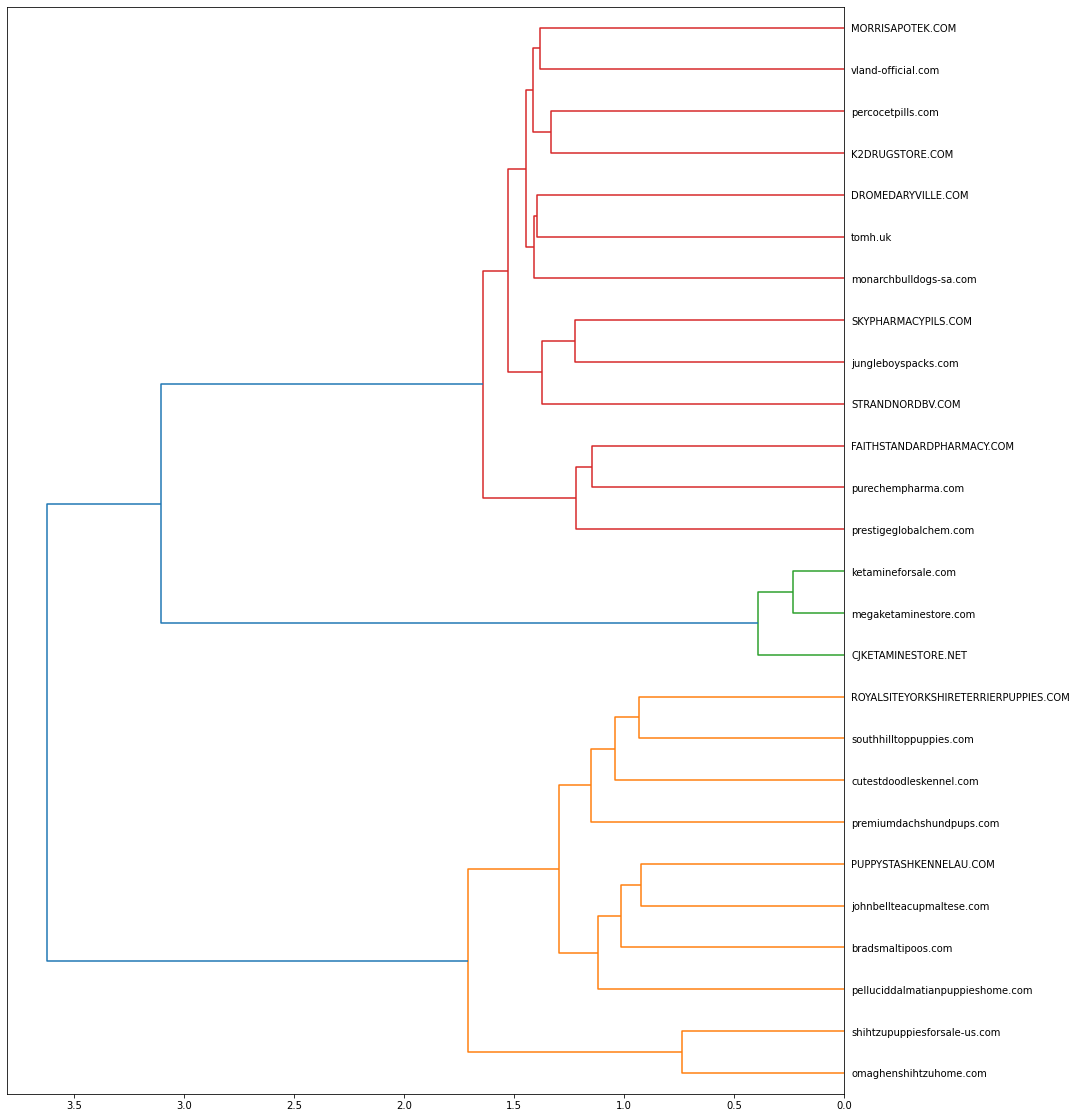

In [207]:
fig, ax = plt.subplots(figsize=(15,20))
ax = dendrogram(Z, orientation="left", labels=list(tokens.keys()))

In [68]:
fcluster(Z, 0.9, criterion='distance')

array([7, 1, 5, 4, 8, 6, 9, 2, 1, 1, 3], dtype=int32)

# T-SNE

In [142]:
from sklearn.manifold import TSNE

In [143]:
tsne = TSNE(n_components=2, learning_rate='auto')

TSNE_clusters = tsne.fit_transform(tfidf_matrix)

/home/connor/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [161]:
TSNE_clusters

data = {'tsne-1': TSNE_clusters[:, 0], 'tsne-2': TSNE_clusters[:, 1], 'y': y}

plot_tsne_df = pd.DataFrame(data)
plot_tsne_df

,tsne-1,tsne-2,y
0,102.493866,33.272102,0
1,21.955439,40.880768,1
2,26.724407,-32.817394,0
3,-31.759233,101.498535,4
4,57.446392,110.992821,2
5,-100.383141,54.650162,0
6,-42.664532,-85.461624,2
7,-40.777489,1.815273,3
8,37.395897,-111.934486,1
9,-111.005966,-36.201389,1


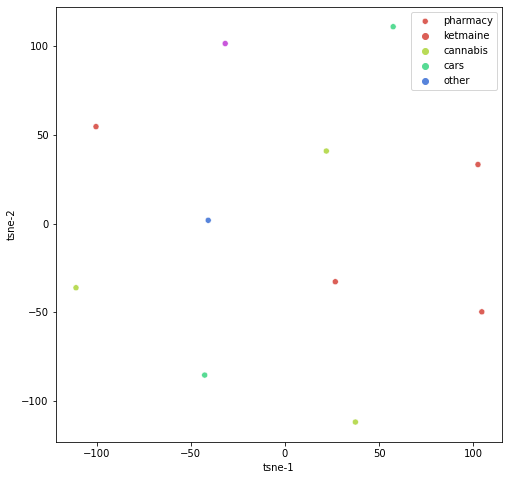

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=plot_tsne_df,
    legend="full",
)
plt.legend(labels=["pharmacy", "ketmaine", "cannabis", "cars", "other"])

In [145]:
tsne_kmeans = KMeans(n_clusters=5)

tsne_kmeans_clusters = kmeans.fit_transform(TSNE_clusters)

cluster_labels = kmeans.labels_

In [149]:
tsne_domains = {'domain': tokens.keys(), 'cluster': cluster_labels, 'total_spent': list(costs.values())}

tsne_df = pd.DataFrame(tsne_domains, index=[clusters], columns=['domain', 'cluster', 'total_spent'])

tsne_df

,domain,cluster,total_spent
0,prestigeglobalchem.com,2,36.50000
0,CJKETAMINESTORE.NET,2,55.00000
2,purechempharma.com,0,24.00000
1,tomh.uk,4,18.00000
2,jungleboyspacks.com,2,16.88000
2,FAITHSTANDARDPHARMACY.COM,4,12.00000
4,K2DRUGSTORE.COM,1,18.00000
1,vland-official.com,1,123.66876
0,megaketaminestore.com,3,24.00000
0,ketamineforsale.com,1,28.88000


In [150]:
tsne_total_spent = tsne_df['total_spent'].groupby(tsne_df['cluster'])

tsne_total_spent.mean()

cluster
0    18.000000
1    56.849587
2    36.126667
3    24.000000
4    15.000000
Name: total_spent, dtype: float64

In [151]:
grouped_df = tsne_df.groupby('cluster')
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

               domain  cluster  total_spent
2  purechempharma.com        0         24.0
3    MORRISAPOTEK.COM        0         12.0 


                domain  cluster  total_spent
4      K2DRUGSTORE.COM        1     18.00000
1   vland-official.com        1    123.66876
0  ketamineforsale.com        1     28.88000 


                   domain  cluster  total_spent
0  prestigeglobalchem.com        2        36.50
0     CJKETAMINESTORE.NET        2        55.00
2     jungleboyspacks.com        2        16.88 


                  domain  cluster  total_spent
0  megaketaminestore.com        3         24.0 


                      domain  cluster  total_spent
1                    tomh.uk        4         18.0
2  FAITHSTANDARDPHARMACY.COM        4         12.0 


